Statistical Theory --- Final Project
---
**Class-based Question Notebook**

By Adam Aharony and Adva Davidof.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Reading dataset from csv
df = pd.read_csv("titanic.csv")
# Dropping unnecessary columns
df.drop(
    columns=[
        "PassengerId",
        "Name",
        "Ticket",
        "Cabin",
        "Embarked"
    ],
    inplace=True
)

# Desired data type for certain columns
types = {
    "Survived": "bool",
    "Pclass": "int8",
    "SibSp": "int8",
    "Parch": "int8",
}
for column, dtype in types.items():
    df[column] = df[column].astype(dtype)

# New 'additional family' feature
df["Family"] = df["SibSp"] + df["Parch"]

In [3]:
# Float precision variable, per column
DEFAULT_PRECISION = 2
COLOURS = {
    "blue": "#008AF3",
    "mid_blue": "#006AB2",
    "dark_blue": "#004676",
    "pink": "#FF027A",
    "red": "#B71C1C",
    "green": "#1B5E20"
}

rc = {
    "text.color": "black",
    "axes.labelcolor": "black",
    "legend.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
}

sns.set_theme(
    context="talk",
    style="whitegrid",
    palette="muted",
    rc=rc
)

## Statistical Tests

In [4]:
from scipy.stats import chi2_contingency, fisher_exact, ttest_ind
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.api import Logit
from statsmodels.genmod.generalized_estimating_equations import GEE
from scipy.stats import permutation_test


ALPHA = 5e-2
# Contingency table
survival_rate_by_class = pd.crosstab(df["Pclass"], df["Survived"])
class_survivors = df.query("Survived == True")["Pclass"]
class_victims = df.query("Survived == False")["Pclass"]
survival_rate_by_class

Survived,False,True
Pclass,,
1,80,136
2,97,87
3,372,119


### Chi-Square Test for Independence


In [5]:
# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(survival_rate_by_class)

# Print results
with np.printoptions(precision=DEFAULT_PRECISION):
    print(f"Chi-Square: {chi2:.{DEFAULT_PRECISION}f}")
    print(f"P-value: {p:.{DEFAULT_PRECISION}e}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Expected counts:\n{expected}")

# Test interpretation
if p < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Chi-Square: 102.89
P-value: 4.55e-23
Degrees of Freedom: 2
Expected counts:
[[133.09  82.91]
 [113.37  70.63]
 [302.54 188.46]]
H_0 can be rejected.


### Fisher's Exact Test


#### Two-Sided

In [6]:
# Since Fisher's Exact Test is designed for 2x2 tables, we split the analysis into pairs of classes
results_table = np.zeros(
    (
        survival_rate_by_class.index.max(),
        survival_rate_by_class.index.max(),
        2
    )
)
# Iterate over all pairs of classes
for i in range(0, results_table.shape[0]):
    for j in range(0, results_table.shape[1]):
        if i != j:
            # odds_ratio, p_value
            results_table[i, j] = fisher_exact(survival_rate_by_class.iloc[[i, j]])

# Print results
with np.printoptions(precision=DEFAULT_PRECISION):
    print(f"Two-Sided Odds Ratios:\n{results_table[:, :, 0]}")
    print(f"Two-Sided P-values:\n{results_table[:, :, 1]}")

# Test interpretation
reject = results_table[:, :, 1] < ALPHA
print(f"Whether or not H_0 can be rejected, sorted by pairs of classes:\n{reject}")

Two-Sided Odds Ratios:
[[0.   0.53 0.19]
 [1.9  0.   0.36]
 [5.31 2.8  0.  ]]
Two-Sided P-values:
[[0.00e+00 1.78e-03 1.79e-22]
 [1.78e-03 0.00e+00 2.14e-08]
 [1.79e-22 2.14e-08 0.00e+00]]
Whether or not H_0 can be rejected, sorted by pairs of classes:
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


#### One-Sided

In [7]:
# Since Fisher's Exact Test is designed for 2x2 tables, we split the analysis into pairs of classes
results_table = np.zeros(
    (
        survival_rate_by_class.index.max(),
        survival_rate_by_class.index.max(),
        2
    )
)
# Iterate over all pairs of classes
for i in range(0, results_table.shape[0]):
    for j in range(0, results_table.shape[1]):
        if i != j:
            # odds_ratio, p_value
            results_table[i, j] = fisher_exact(
                survival_rate_by_class.iloc[[i, j]],
                alternative="greater"
            )

# Print results
with np.printoptions(precision=DEFAULT_PRECISION):
    print(f"One-Sided Odds Ratios:\n{results_table[:, :, 0]}")
    print(f"One-Sided P-values:\n{results_table[:, :, 1]}")

# Test interpretation
reject = results_table[:, :, 1] < ALPHA
print(
    f"Whether or not H_0 can be rejected, sorted by pairs of classes:\n{reject}")

One-Sided Odds Ratios:
[[0.   0.53 0.19]
 [1.9  0.   0.36]
 [5.31 2.8  0.  ]]
One-Sided P-values:
[[0.00e+00 9.99e-01 1.00e+00]
 [1.15e-03 0.00e+00 1.00e+00]
 [1.38e-22 1.18e-08 0.00e+00]]
Whether or not H_0 can be rejected, sorted by pairs of classes:
[[ True False False]
 [ True  True False]
 [ True  True  True]]


### Logistic Regression as a Statistical Test

In [8]:
# Create and fit the logistic regression model
model = Logit(
    df["Survived"].copy(),
    df["Pclass"].copy()
).fit()

# Print p-values
p_value = model.pvalues.iloc[0]
print(f"p-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

model.summary()

Optimization terminated successfully.
         Current function value: 0.637135
         Iterations 4
p-value: 7.25e-22
H_0 can be rejected.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      890
Method:                           MLE   Df Model:                            0
Date:                Sat, 05 Oct 2024   Pseudo R-squ.:                 0.04321
Time:                        19:21:56   Log-Likelihood:                -567.69
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pclass        -0.2834      0.029     -9.610      0.000      -0.341      -0.226
==============================================================================
"""

### Test in the Case of Dependent Samples

#### Generalised Estimating Equations (GEE)


In [9]:
# Create and fit the GEE model
model = GEE(
    df["Survived"].copy(),
    df["Pclass"].copy(),
    groups=df["Pclass"].copy()
).fit()

# Print p-values
p_value = model.pvalues.iloc[0]
print(f"p-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")
    
model.summary()

p-value: 4.64e-03
H_0 can be rejected.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                    Survived   No. Observations:                  891
Model:                                 GEE   No. clusters:                        3
Method:                        Generalized   Min. cluster size:                 184
                      Estimating Equations   Max. cluster size:                 491
Family:                           Gaussian   Mean cluster size:               297.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Sat, 05 Oct 2024   Scale:                           0.291
Covariance type:                    robust   Time:                         19:21:56
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pclass         0.1242      0.044      2.831      0.005       0.038       0.210
==============================================================================
Skew:                          0.4731   Kurtosis:                      -1.6531
Centered skew:                 0.4210   Centered kurtosis:             -1.2768
==============================================================================
"""

#### Logistic Regression with Clustered Standard Errors


In [10]:
# Create and fit the logistic regression model
model = Logit(
    df["Survived"].copy(),
    df["Pclass"].copy()
).fit(
    cov_type="cluster",
    cov_kwds={
        "groups": df["Pclass"].copy()
    }
)

# Print p-values
p_value = model.pvalues.iloc[0]
print(f"p-value: {p_value:.{DEFAULT_PRECISION}e}")

# Test interpretation
if p_value < ALPHA:
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

model.summary()

Optimization terminated successfully.
         Current function value: 0.637135
         Iterations 4
p-value: 9.71e-03
H_0 can be rejected.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      890
Method:                           MLE   Df Model:                            0
Date:                Sat, 05 Oct 2024   Pseudo R-squ.:                 0.04321
Time:                        19:21:56   Log-Likelihood:                -567.69
converged:                       True   LL-Null:                       -593.33
Covariance Type:              cluster   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pclass        -0.2834      0.110     -2.586      0.010      -0.498      -0.069
==============================================================================
"""

#### Permutation Test


##### Two-Sided

In [11]:
N_PERMUTATIONS = 1000
results_table = np.zeros((df["Pclass"].max(), 2))

# Iterate over all classes
for class_idx in df["Pclass"].unique():
    # Split the data into the class of interest
    class_survival = df[df["Pclass"] == class_idx]["Survived"]
    non_class_survival = df[df["Pclass"] != class_idx]["Survived"]
    # Perform permuation test
    result = permutation_test(
        data=(class_survival, non_class_survival),
        statistic=lambda c, nc: np.mean(c) - np.mean(nc),
        permutation_type="independent",
        n_resamples=N_PERMUTATIONS,
        alternative="two-sided"
    )
    results_table[class_idx - 1] = result.statistic, result.pvalue

# Print results
print(f"Two-Sided Statistics: {results_table[..., 0]}")
print(f"Two-Sided P-values: {results_table[..., 1]}")

# Test interpretation
if np.all(results_table[..., 1] < ALPHA):
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

Two-Sided Statistics: [ 0.32444444  0.11214716 -0.31513747]
Two-Sided P-values: [0.001998   0.01398601 0.001998  ]
H_0 can be rejected.


##### One-Sided

In [12]:
N_PERMUTATIONS = 1000
results_table = np.zeros((df["Pclass"].max(), 2))

# Iterate over all classes
for class_idx in df["Pclass"].unique():
    # Split the data into the class of interest
    class_survival = df[df["Pclass"] == class_idx]["Survived"]
    non_class_survival = df[df["Pclass"] != class_idx]["Survived"]
    # Perform permuation test
    result = permutation_test(
        data=(class_survival, non_class_survival),
        statistic=lambda c, nc: np.mean(c) - np.mean(nc),
        permutation_type="independent",
        n_resamples=N_PERMUTATIONS,
        alternative="greater"
    )
    results_table[class_idx - 1] = result.statistic, result.pvalue

# Print results
print(f"One-Sided Statistics: {results_table[..., 0]}")
print(f"One-Sided P-values: {results_table[..., 1]}")

# Test interpretation
if np.all(results_table[..., 1] < ALPHA):
    print("H_0 can be rejected.")
else:
    print("H_0 cannot be rejected.")

One-Sided Statistics: [ 0.32444444  0.11214716 -0.31513747]
One-Sided P-values: [9.99000999e-04 7.99200799e-03 1.00000000e+00]
H_0 cannot be rejected.


## People Count per Class

### People Count per Class (raw)

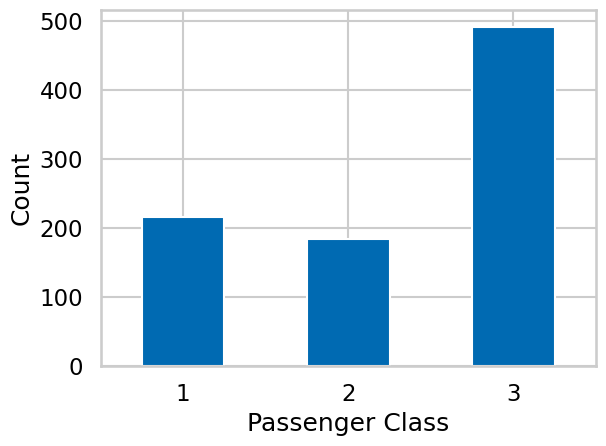

In [13]:
# Calculate the count of each passenger class
people_per_class = df["Pclass"].value_counts().sort_index()

# Plot the count of each passenger class
people_per_class.plot(
    kind="bar",
    xlabel="Passenger Class",
    ylabel="Count",
    color=COLOURS["mid_blue"]
)
# Rotate x-axis labels
plt.xticks(rotation=0)

# Save the plot as a PDF file
plt.tight_layout()
plt.savefig("figures/class_raw.pdf", bbox_inches="tight")
plt.savefig("figures/class_raw.pgf", bbox_inches="tight")

### People Count per Class (normalised)

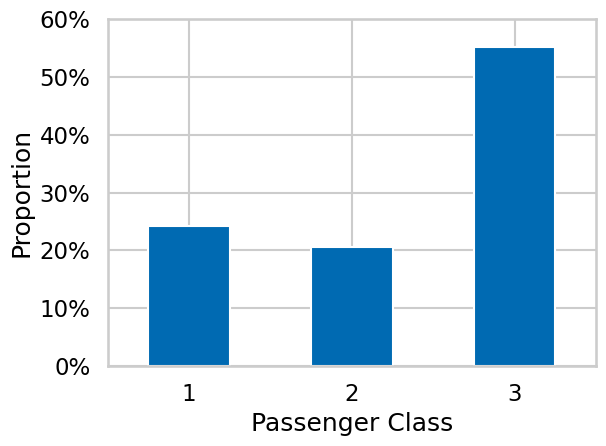

In [14]:
# Calculate the rate of each passenger class
people_per_class = df["Pclass"].value_counts(normalize=True).sort_index()

# Plot the rate of each passenger class
people_per_class.plot(
    kind="bar",
    xlabel="Passenger Class",
    ylabel="Proportion",
    color=COLOURS["mid_blue"]
)
# Rotate x-axis labels
plt.xticks(rotation=0)
# Change y-labels to percentages
y_ticks = [f"{y:.0%}" for y in plt.yticks()[0]]
plt.yticks(plt.yticks()[0], y_ticks)

# Save the plot as a PDF file
plt.tight_layout()
plt.savefig("figures/class_normalised.pdf", bbox_inches="tight")
plt.savefig("figures/class_normalised.pgf", bbox_inches="tight")

## Survival Rate by Class

### Survival rate by class (raw)

In [15]:
survival_rate_by_class = pd.crosstab(df["Pclass"], df["Survived"])
styler = survival_rate_by_class.style
# Format the indices of the styler object with bold text using LaTeX formatting
styler.format_index("\\textbf{{{}}}", axis=0, escape="latex")
styler.format_index("\\textbf{{{}}}", axis=1, escape="latex")
# Convert the styler object to LaTeX and save it as a table in a .tex file
styler.to_latex("tables/survival-class_raw.tex", hrules=True)
# Display the survival rate by class dataframe
survival_rate_by_class

Survived,False,True
Pclass,,
1,80,136
2,97,87
3,372,119


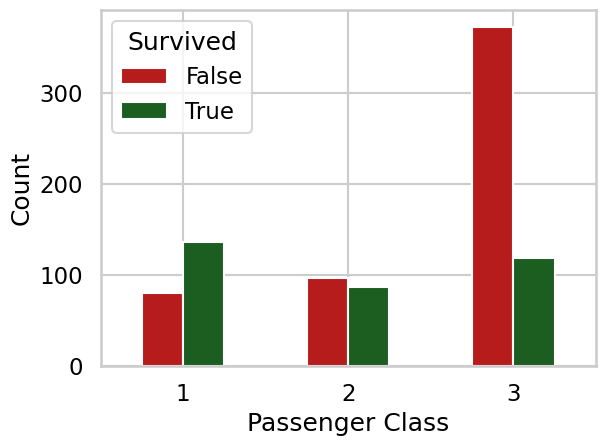

In [16]:
# Plot the survival rate by class (raw)
survival_rate_by_class.plot(
    xlabel="Passenger Class",
    ylabel="Count",
    kind="bar",
    stacked=False,
    color=[COLOURS["red"], COLOURS["green"]]
)
# Rotate x-axis labels
plt.xticks(rotation=0)
# Save the plot as a PDF file
plt.tight_layout()
plt.savefig("figures/survival-class_raw.pdf", bbox_inches="tight")
plt.savefig("figures/survival-class_raw.pgf", bbox_inches="tight")

### Survival rate by class (normalised)

In [17]:
# Calculate the survival rate by class
survival_rate_by_class = pd.crosstab(df["Pclass"], df["Survived"], normalize="index")

# Apply formatting to the DataFrame for styling
styler = survival_rate_by_class.style
styler.format_index("\\textbf{{{}}}", axis=0, escape="latex")
styler.format_index("\\textbf{{{}}}", axis=1, escape="latex")
styler.format(
    subset=None,
    formatter=lambda x: f"{100*x:.{DEFAULT_PRECISION}f}"+"\%"
)
# Convert the styled DataFrame to LaTeX and save it as a table in a .tex file
styler.to_latex("tables/survival-class_normalised.tex", hrules=True)
# Display the survival rate by class DataFrame
survival_rate_by_class

Survived,False,True
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


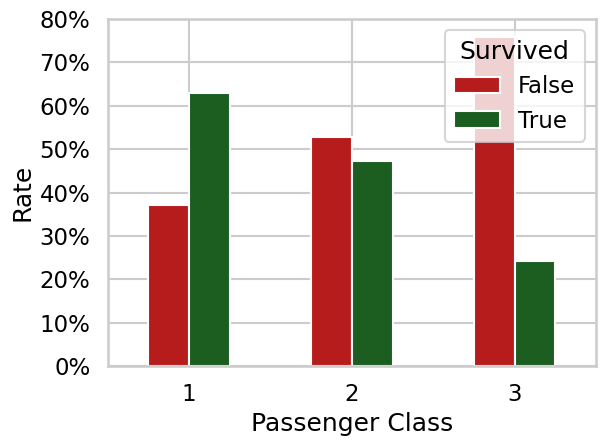

In [18]:
# Plot the survival rate by class (normalised)
survival_rate_by_class.plot(
    xlabel="Passenger Class",
    ylabel="Rate",
    kind="bar",
    stacked=False,
    color=[COLOURS["red"], COLOURS["green"]]
)
# Change y-labels to percentages
y_ticks = [f"{y:.0%}" for y in plt.yticks()[0]]
plt.yticks(plt.yticks()[0], y_ticks)
# Rotate x-axis labels
plt.xticks(rotation=0)
# Save the plot as a PDF file
plt.tight_layout()
plt.savefig("figures/survival-class_normalised.pdf", bbox_inches="tight")
plt.savefig("figures/survival-class_normalised.pgf", bbox_inches="tight")